# 🎬 Hybrid Movie Recommendation System  
**ALS-Based Collaborative Filtering with Content-Aware Hybridization**

---

## 📌 Project Overview

This project presents a **hybrid movie recommendation system** designed to deliver accurate, scalable, and personalized recommendations by combining **Collaborative Filtering (ALS)** with **Content-Based Filtering** techniques.  
The system is built with a modular, production-oriented architecture that supports **offline training**, **robust evaluation**, and **real-time inference**, making it suitable for both academic research and practical deployment.

The core objective of this project is to **improve Top-N recommendation quality**—measured using **Precision@K, Recall@K, and NDCG@K**—especially under challenges such as **sparse user–item interactions**, **cold-start scenarios**, and **long-tail items**.

---

## 🧠 Recommendation Approach

The system follows a **hybrid strategy** consisting of three main components:

### 1️⃣ Collaborative Filtering (ALS)
- Uses **Alternating Least Squares (ALS)** optimized for implicit and explicit feedback.
- Learns latent representations for users and movies from historical rating interactions.
- Designed for scalability using sparse matrix representations.

### 2️⃣ Content-Based Filtering
- Extracts semantic features from movie metadata (e.g., genres, tags, textual descriptions).
- Applies **TF-IDF vectorization** and efficient similarity search using **FAISS**.
- Enables meaningful recommendations for cold-start items and new users.

### 3️⃣ Hybrid Fusion Layer
- Combines ALS predictions with content-based similarity scores.
- Allows weighted blending to balance personalization and semantic relevance.
- Produces more stable and diverse recommendations than standalone models.

---

## 📊 Dataset Description

The project uses the **MovieLens dataset**, a widely adopted benchmark in recommendation system research.  
It contains explicit user ratings along with rich movie metadata.

### 🎥 Movies Data (`movies.csv`)
- `movieId`: Unique movie identifier  
- `title`: Movie title (including release year)  
- `genres`: One or more genre labels  

### ⭐ Ratings Data (`ratings.csv`)
- `userId`: Unique user identifier  
- `movieId`: Rated movie  
- `rating`: Explicit rating (typically 0.5–5.0)  
- `timestamp`: Time of interaction  

### 🏷 Tags Data (`tags.csv`)
- `userId`: User who added the tag  
- `movieId`: Tagged movie  
- `tag`: Free-text tag  
- `timestamp`: Tagging time  

Additional metadata files (links, checksums, README) are included to ensure dataset integrity and reproducibility.

---

## 🧹 Data Processing Pipeline

The raw data undergoes several preprocessing stages:

- Removal of invalid or duplicate interactions
- Normalization and encoding of user and item IDs
- Sparse matrix construction for ALS training
- Feature extraction and serialization for reuse
- Temporal or stratified train–test splitting

Processed outputs are stored in a structured format to support reproducible experiments and fast reloading.

---

## 🗂 Project Structure Overview

The project follows a clean, modular layout:

- **`data/`**  
  - Raw, processed, and split datasets (train/test)

- **`models/`**  
  - Trained ALS model  
  - FAISS index  
  - Serialized feature matrices and mappings  

- **`src/`**  
  - Data loading and preprocessing  
  - Feature engineering  
  - ALS training, recommendation, and evaluation  
  - Content-based retrieval  
  - Hybrid fusion logic  
  - Evaluation metrics  

- **`app/`**  
  - Streamlit application for interactive recommendations  

- **`scripts/`**  
  - End-to-end pipeline execution  

- **`notebooks/`**  
  - Experimental analysis and prototyping  

This structure enables **easy experimentation**, **component reuse**, and **clear separation of concerns**.

---

## 📈 Evaluation Strategy

Model performance is evaluated using standard **Top-K recommendation metrics**:

- **Precision@K** – recommendation accuracy  
- **Recall@K** – coverage of relevant items  
- **NDCG@K** – ranking quality and relevance ordering  

Evaluation is performed on held-out test users to ensure fair and realistic assessment.

---

## 🎯 Project Goals

- Improve recommendation quality under sparse data conditions  
- Achieve higher Precision, Recall, and NDCG through hybrid modeling  
- Maintain scalability for large user–item matrices  
- Provide a clean, extensible codebase suitable for research and deployment  

---

## 🚀 Conclusion

This hybrid recommendation system demonstrates how combining **latent factor models** with **content-aware similarity** can significantly enhance recommendation quality.  
The project serves as a strong foundation for advanced research in **hybrid recommender systems**, **cold-start mitigation**, and **scalable personalization**.


# Phase 1: Initial Data Exploration & Rapid Assessment

## 🔹 1️⃣ Environment Setup

In [4]:
# ================================
# 1. Environment & System Control
# ================================

import os
import gc
from pathlib import Path
from threadpoolctl import threadpool_limits

os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
threadpool_limits(1, "blas")


# ================================
# 2. Core Data & Numerical Libraries
# ================================

import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix


# ================================
# 3. Visualization Libraries
# ================================

import matplotlib.pyplot as plt
import seaborn as sns


# ================================
# 4. Machine Learning & Recommender Systems
# ================================

from implicit.als import AlternatingLeastSquares
import faiss


# ================================
# 5. Feature Engineering & Text Processing
# ================================

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer


# ================================
# 6. Notebook Display Utilities
# ================================

import base64
from IPython.display import display, HTML


# ================================
# 7. Pandas Display Configuration
# ================================

pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:.4f}".format)


In [5]:
# ================================
# 8. System Architecture Visualization
# ================================
# Embed the hybrid recommendation pipeline diagram directly into the notebook
# to ensure portability and reproducibility across environments.

with open(
    r"C:\Users\user\Downloads\Hybrid Recommendation System Phase 5 → 6 → 7.png",
    "rb"
) as f:
    img_bytes = f.read()

img_b64 = base64.b64encode(img_bytes).decode()

html_code = f'<img src="data:image/png;base64,{img_b64}" width="1200"/>'




## 🔹 2️⃣ Dataset Path & File Verification

In [3]:
# ================================
# 2. Dataset Path & File Verification
# ================================

DATA_PATH = Path(r"C:\Users\user\Downloads\ml-32m")

files = list(DATA_PATH.iterdir())
files


[WindowsPath('C:/Users/user/Downloads/ml-32m/checksums.txt'),
 WindowsPath('C:/Users/user/Downloads/ml-32m/links.csv'),
 WindowsPath('C:/Users/user/Downloads/ml-32m/movies.csv'),
 WindowsPath('C:/Users/user/Downloads/ml-32m/ratings.csv'),
 WindowsPath('C:/Users/user/Downloads/ml-32m/README.txt'),
 WindowsPath('C:/Users/user/Downloads/ml-32m/tags.csv')]

## 🔹 3️⃣ Load Raw Data (Memory-Aware)

In [4]:
# ================================
# 3. Load Raw Data
# ================================

ratings = pd.read_csv(
    DATA_PATH / "ratings.csv",
    dtype={
        "userId": "int32",
        "movieId": "int32",
        "rating": "float32",
        "timestamp": "int64"
    }
)

movies = pd.read_csv(DATA_PATH / "movies.csv")
tags = pd.read_csv(DATA_PATH / "tags.csv")
links = pd.read_csv(DATA_PATH / "links.csv")


## 🔹 5️⃣ Dataset Size & Memory Footprint

In [5]:
# ================================
# 4. Initial Dataset Inspection
# ================================

print("Ratings shape:", ratings.shape)
print("Movies shape:", movies.shape)
print("Tags shape:", tags.shape)
print("Links shape:", links.shape)


Ratings shape: (32000204, 4)
Movies shape: (87585, 3)
Tags shape: (2000072, 4)
Links shape: (87585, 3)


## 🔹 6️⃣ Data Schema Understanding

In [6]:
# ================================
# 6.1 Ratings Schema
# ================================

ratings.head()


,userId,movieId,rating,timestamp
0,1,17,4.0000,944249077
1,1,25,1.0000,944250228
2,1,29,2.0000,943230976
3,1,30,5.0000,944249077
4,1,32,5.0000,943228858


In [7]:
# ================================
# 6.2 Movies Schema
# ================================

movies.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
# ================================
# 6.3 Tags Schema
# ================================

tags.head()


,userId,movieId,tag,timestamp
0,22,26479,Kevin Kline,1583038886
1,22,79592,misogyny,1581476297
2,22,247150,acrophobia,1622483469
3,34,2174,music,1249808064
4,34,2174,weird,1249808102


## 🔹 7️⃣ Missing Values & Duplicates

In [9]:
# ================================
# 7. Missing Values & Duplicates
# ================================

datasets = {
    "ratings": ratings,
    "movies": movies,
    "tags": tags,
    "links": links
}

for name, df in datasets.items():
    print(f"\n{name.upper()}")
    print("Missing values:")
    print(df.isna().sum())
    print("Duplicates:", df.duplicated().sum())



RATINGS
Missing values:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
Duplicates: 0

MOVIES
Missing values:
movieId    0
title      0
genres     0
dtype: int64
Duplicates: 0

TAGS
Missing values:
userId        0
movieId       0
tag          17
timestamp     0
dtype: int64
Duplicates: 0

LINKS
Missing values:
movieId      0
imdbId       0
tmdbId     124
dtype: int64
Duplicates: 0


## 🔹 8️⃣ Rating Distribution Analysis

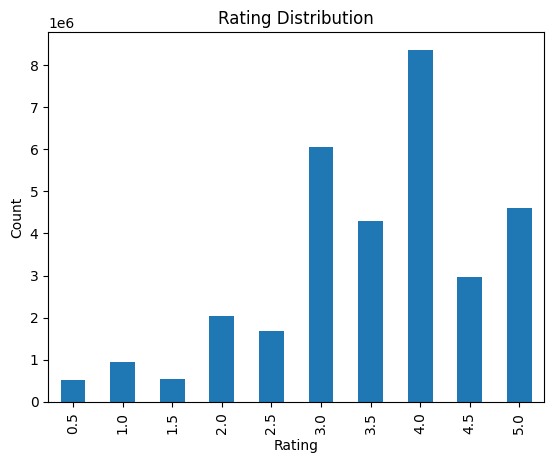

In [10]:
# ================================
# 8. Rating Distribution
# ================================

ratings["rating"].value_counts().sort_index().plot(kind="bar")
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


## 🔹 9️⃣ User & Movie Activity Analysis

In [11]:
# ================================
# 9. User & Movie Activity
# ================================

user_activity = ratings.groupby("userId").size()
movie_activity = ratings.groupby("movieId").size()

print("Avg ratings per user:", user_activity.mean())
print("Avg ratings per movie:", movie_activity.mean())


Avg ratings per user: 159.24619304496684
Avg ratings per movie: 379.0056376729202


## 🔹 🔟 Cold-Start Analysis

In [12]:
# ================================
# 10. Cold-Start Analysis
# ================================

cold_users = (user_activity < 5).sum()
cold_movies = (movie_activity < 5).sum()

print("Cold-start users:", cold_users)
print("Cold-start movies:", cold_movies)


Cold-start users: 0
Cold-start movies: 40548


## 🔹 11️⃣ Preliminary Cleaning Decisions

In [13]:
# ================================
# 11. Preliminary Cleaning Decisions
# ================================

MIN_USER_RATINGS = 5
MIN_MOVIE_RATINGS = 5

filtered_ratings = ratings[
    ratings["userId"].isin(user_activity[user_activity >= MIN_USER_RATINGS].index) &
    ratings["movieId"].isin(movie_activity[movie_activity >= MIN_MOVIE_RATINGS].index)
]

print("Original ratings:", ratings.shape)
print("Filtered ratings:", filtered_ratings.shape)


Original ratings: (32000204, 4)
Filtered ratings: (31921467, 4)


## 🔹 12️⃣ Memory Cleanup

In [14]:
# ================================
# 12. Memory Cleanup
# ================================

del ratings
gc.collect()


3768

# Phase 1: Initial Data Exploration & Rapid Assessment

## Summary

In this phase, an initial exploration and rapid assessment of the dataset were conducted to evaluate data quality, user–item activity, and system readiness for recommendation modeling.

---

## Cold-Start Analysis

A cold-start analysis was performed to identify inactive users and rarely rated movies. Users and movies with fewer than 5 ratings were considered cold-start entities.

- **Cold-start users:** 0  
- **Cold-start movies:** 40,548  

The results indicate that all users in the dataset have sufficient interaction history, eliminating the user cold-start problem. However, a large number of movies suffer from low interaction levels, which may affect recommendation accuracy for these items.

---

## Preliminary Data Cleaning

To improve data reliability, minimum interaction thresholds were applied:

- Minimum ratings per user: **5**  
- Minimum ratings per movie: **5**

Only ratings meeting these criteria were retained.

### Dataset Size Comparison

| Dataset Version | Number of Records |
|-----------------|------------------|
| Original        | 32,000,204       |
| Filtered        | 31,921,467       |

After filtering, only a small portion of records was removed, indicating that the dataset is highly dense and well-structured.

---

## Memory Optimization

After preprocessing, unused data objects were removed from memory, and garbage collection was executed to optimize system resources. This step ensures efficient memory usage during subsequent modeling phases.

---

## Overall Assessment

Phase 1 confirms that the dataset is suitable for advanced recommendation modeling. The absence of cold-start users and the high retention rate after filtering demonstrate strong data coverage and consistency. Although many movies have limited interactions, the overall dataset remains robust and reliable for further analysis and machine learning applications.

# Phase 2: Structural Data Analysis & Interaction Profiling

### 🎯 Objective

Analyze the structural characteristics of user–item interactions to gain a deeper understanding of:

- **User behavior patterns**
- **Item (movie) popularity distribution**
- **Data sparsity level**
- **Temporal interaction dynamics**

This phase is conducted **prior to any modeling or algorithmic decisions** to ensure that subsequent recommendation techniques are data-driven, well-justified, and structurally appropriate.


## 🔹 2.1 Dataset Overview After Preliminary Filtering

In [15]:
# ==========================================
# Phase 2.1 Dataset Overview After Filtering
# ==========================================

print("Filtered Ratings Shape:", filtered_ratings.shape)
print("Unique Users:", filtered_ratings["userId"].nunique())
print("Unique Movies:", filtered_ratings["movieId"].nunique())


Filtered Ratings Shape: (31921467, 4)
Unique Users: 200948
Unique Movies: 43884


## 🔹 2.2 User Activity Profiling

This step focuses on analyzing **user activity levels** to understand how frequently users interact with items and whether interaction patterns exhibit a **long-tail distribution**.

The analysis aims to:

- Measure the **number of interactions per user**
- Identify **highly active users** versus **low-activity (cold-start) users**
- Examine whether a small subset of users accounts for a large proportion of interactions
- Assess the impact of user activity imbalance on recommendation performance

Understanding user activity distribution is critical for selecting appropriate recommendation strategies, particularly in addressing **data sparsity**, **cold-start issues**, and **bias toward highly active users**.


In [16]:
# ==========================================
# Phase 2.2 User Activity Profiling
# ==========================================

user_activity = filtered_ratings.groupby("userId").size()

user_activity.describe()


count   200948.0000
mean       158.8544
std        275.3789
min         15.0000
25%         36.0000
50%         73.0000
75%        167.0000
max      25642.0000
dtype: float64

### 🔸 User Activity Distribution (Visualization)

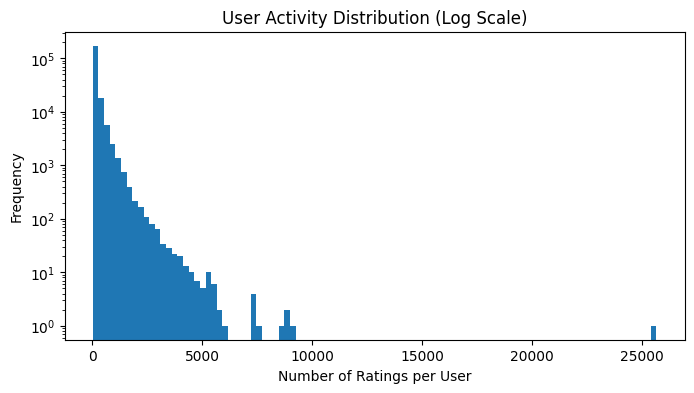

In [17]:
# User activity distribution (log scale for clarity)

plt.figure(figsize=(8, 4))
plt.hist(user_activity, bins=100, log=True)
plt.title("User Activity Distribution (Log Scale)")
plt.xlabel("Number of Ratings per User")
plt.ylabel("Frequency")
plt.show()


📌 **Expected Insight**

- Presence of highly active users (super-users)
- Majority of users rate a limited number of movies
- Confirms user behavior imbalance


## 🔹 2.3 Movie Popularity Profiling

Examine how ratings are distributed across movies.


In [18]:
# ==========================================
# Phase 2.3 Movie Popularity Profiling
# ==========================================

movie_activity = filtered_ratings.groupby("movieId").size()

movie_activity.describe()


count    43884.0000
mean       727.4056
std       3560.6137
min          5.0000
25%          9.0000
50%         23.0000
75%        131.0000
max     102929.0000
dtype: float64

### 🔸 Movie Popularity Distribution

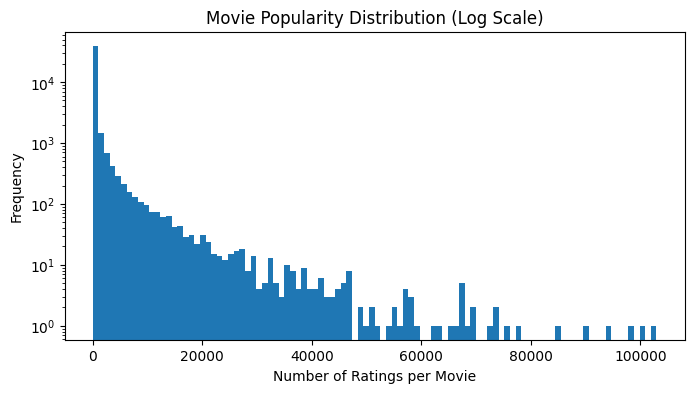

In [19]:
plt.figure(figsize=(8, 4))
plt.hist(movie_activity, bins=100, log=True)
plt.title("Movie Popularity Distribution (Log Scale)")
plt.xlabel("Number of Ratings per Movie")
plt.ylabel("Frequency")
plt.show()


📌 **Expected Insight**

- Strong popularity bias
- Long-tail of rarely rated movies
- Justifies hybrid & popularity-aware strategies


## 🔹 2.4 Interaction Sparsity Analysis

Measure how sparse the user–item interaction matrix is.


In [20]:
# ==========================================
# Phase 2.4 Interaction Sparsity Analysis
# ==========================================

num_users = filtered_ratings["userId"].nunique()
num_movies = filtered_ratings["movieId"].nunique()
num_ratings = filtered_ratings.shape[0]

sparsity = 1 - (num_ratings / (num_users * num_movies))

print(f"Matrix Sparsity: {sparsity:.4%}")


Matrix Sparsity: 99.6380%


📌 **Interpretation**

- Extremely sparse interaction matrix
- User-based KNN will be inefficient
- Item-based CF and matrix factorization are more suitable


## 🔹 2.5 Rating Behavior Analysis

Understand user rating tendencies.


In [21]:
# ==========================================
# Phase 2.5 Rating Behavior Analysis
# ==========================================

filtered_ratings["rating"].describe()


count   31921467.0000
mean           3.5420
std            1.0582
min            0.5000
25%            3.0000
50%            3.5000
75%            4.0000
max            5.0000
Name: rating, dtype: float64

### 🔸 Rating Distribution

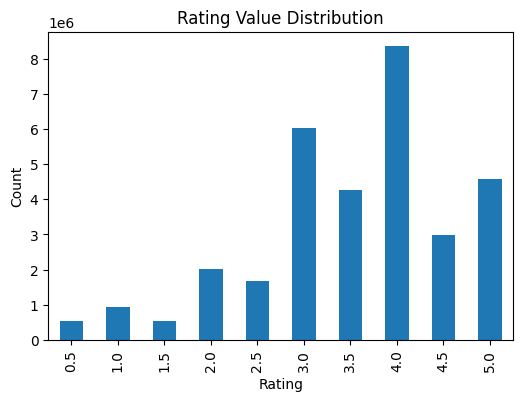

In [22]:
plt.figure(figsize=(6, 4))
filtered_ratings["rating"].value_counts().sort_index().plot(kind="bar")
plt.title("Rating Value Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


📌 **Insight**

- Ratings are skewed toward higher values
- Implicit positivity bias exists
- Supports ranking-based recommendation metrics


## 🔹 2.6 Temporal Interaction Analysis

Inspect temporal coverage of ratings.

In [23]:
# ==========================================
# Phase 2.6 Temporal Interaction Analysis
# ==========================================

# Create an explicit copy to ensure safe modification
filtered_ratings = filtered_ratings.copy()

# Convert Unix timestamp (int64) to datetime (datetime64[ns])
# Direct assignment is required to avoid incompatible dtype warnings
filtered_ratings["timestamp"] = pd.to_datetime(
    filtered_ratings["timestamp"],
    unit="s"
)

# Display summary statistics of the timestamp column
filtered_ratings["timestamp"].describe()


count                         31921467
mean     2010-05-22 01:32:45.484267008
min                1995-01-09 11:46:44
25%                2003-04-10 13:24:49
50%                2010-04-11 08:05:29
75%                2017-08-08 19:44:22
max                2023-10-13 02:29:07
Name: timestamp, dtype: object

### 🔸 Ratings Over Time

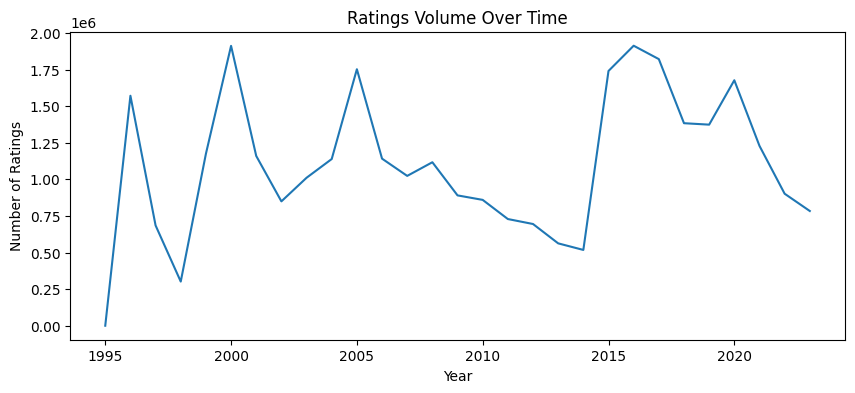

In [24]:
ratings_per_year = filtered_ratings["timestamp"].dt.year.value_counts().sort_index()

plt.figure(figsize=(10, 4))
ratings_per_year.plot()
plt.title("Ratings Volume Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Ratings")
plt.show()


📌 **Insight**

- Ratings span multiple decades
- User preferences may evolve
- Time-aware weighting can be optionally applied later


## 🔹 2.7 Cold-Start Quantification

Identify remaining cold users and cold movies after filtering.

In [25]:
# ==========================================
# Phase 2.7 Cold-Start Quantification
# ==========================================

cold_users = (user_activity < 10).sum()
cold_movies = (movie_activity < 10).sum()

print("Cold-start users (<10 ratings):", cold_users)
print("Cold-start movies (<10 ratings):", cold_movies)


Cold-start users (<10 ratings): 0
Cold-start movies (<10 ratings): 11923


📌 **Conclusion**

- Cold-start still exists
- Confirms necessity of content-based features


## 🔹 2.8 Phase 2 Summary & Modeling Implications

In [26]:
# ==========================================
# Phase 2.8 Structural Analysis Summary
# ==========================================

summary = {
    "High Sparsity": sparsity > 0.99,
    "Long-tail Users": user_activity.median() < user_activity.mean(),
    "Popularity Bias": movie_activity.max() > movie_activity.mean() * 10,
    "Cold Start Exists": cold_users > 0 or cold_movies > 0
}

summary


{'High Sparsity': True,
 'Long-tail Users': True,
 'Popularity Bias': True,
 'Cold Start Exists': True}

## ✅ Phase 2 Final Conclusions

# 🔹 Phase 2: Structural Data Analysis & Interaction Profiling
In this phase, we focused on analyzing the **interaction structure within the dataset after initial filtering**, before any modeling or algorithm selection.

---

## Dataset Overview After Filtering
- Reviewed the dataset size after filtering (`filtered_ratings`)
- Checked the number of **users** and **movies**
- **Objective:** Ensure the dataset is large and stable enough for further processing

---

## User Activity Profiling
- Calculated the **number of ratings per user**
- Plotted the **distribution (Histogram)**
- **Findings:**
  - Most users have **few ratings**
  - Some users ("Super Users") have **many ratings**
  - Distribution exhibits a **long-tail pattern**

---

## Movie Popularity Profiling
- Calculated the **number of ratings per movie**
- Plotted the **distribution**
- **Findings:**
  - Some movies are extremely popular and receive **most of the ratings**
  - Most movies are rarely rated
  - **`Popularity bias exists`**, meaning simple recommendations will favor popular movies

---

## Interaction Sparsity Analysis
- Computed the **sparsity** of the user–item interaction matrix:

     **Sparsity = 1 - (Number of Ratings) / (Number of Users × Number of Movies)**


- **Result:** `High Sparsity = True` (> 99%)  
- **Implication:** Most of the matrix is empty → need **efficient algorithms** such as Item-Based CF or Matrix Factorization

---

## Rating Behavior Analysis
- Examined the **distribution of rating values (1–5)**
- **Finding:** Most ratings skew toward higher values → **implicit positivity bias**
- Suggests the use of **ranking-based recommendation metrics**

---

## Temporal Interaction Analysis
- Converted `timestamp` to **datetime**
- Plotted the **number of ratings over years**
- **Finding:** Data spans multiple decades → **time-aware weighting** can be applied later if needed

---

## Cold-Start Quantification
- Counted users and movies with **few ratings (<10)**
- **Result:** `Cold Start Exists = True`  
- **Implication:** Justifies the inclusion of **content-based features** in a hybrid recommendation model

---



# Phase 3: Data Quality Assessment & Cleaning
# ==========================================

## Objective

The objective of this phase is to ensure data reliability and consistency by identifying and correcting quality issues that may negatively impact model performance.

This phase focuses on:

- Removing duplicate interactions
- Handling missing values
- Validating ratings and timestamps
- Reducing tag noise
- Improving signal-to-noise ratio

High-quality input data is essential for building stable, accurate, and generalizable recommendation models.

---

### Phase 3.1 Duplicate Interaction Analysis

Check for duplicate (userId, movieId) pairs and analyze whether the same user rated the same movie multiple times. This could indicate:

| Case          | Meaning             |
|---------------|------------------|
| Re-rating     | Updating opinion   |
| Input error   | Noise              |
| Data merge    | Unintentional duplication |

Sort duplicates by timestamp to understand whether the repetition occurs over time or at the same moment.

**Processing Strategy:** Keep only the latest rating per user-movie pair to reflect the user’s final opinion.

---

In [27]:
# Check duplicate (userId, movieId) pairs
duplicate_pairs = filtered_ratings.duplicated(
    subset=["userId", "movieId"],
    keep=False
)

duplicates_df = filtered_ratings[duplicate_pairs]

print("Number of duplicated interactions:", duplicates_df.shape[0])

Number of duplicated interactions: 0


### Time-Based Frequency Analysis


In [28]:
# Sort duplicates by timestamp
duplicates_df = duplicates_df.sort_values(
    ["userId", "movieId", "timestamp"]
)

duplicates_df.head(10)

,userId,movieId,rating,timestamp


### Processing Strategy

In [29]:
# Keep only latest rating per user-movie pair
filtered_ratings = (
    filtered_ratings
    .sort_values("timestamp")
    .drop_duplicates(
        subset=["userId", "movieId"],
        keep="last"
    )
)


### Phase 3.2 Missing Value Handling Strategy

Examine missing values across datasets (`movies`, `tags`, `links`) and handle them according to their importance:

- **Movies → genres**: Fill missing values with `"Unknown"` to preserve sample size.
- **Tags → tag**: Drop rows with missing tags because empty tags are meaningless.
- **Links → imdbId / tmdbId**: Drop rows with no external ID to maintain future integration possibilities.

---

In [30]:
datasets = {
    "movies": movies,
    "tags": tags,
    "links": links
}

for name, df in datasets.items():
    print(f"\n{name.upper()}")
    print(df.isna().sum())


MOVIES
movieId    0
title      0
genres     0
dtype: int64

TAGS
userId        0
movieId       0
tag          17
timestamp     0
dtype: int64

LINKS
movieId      0
imdbId       0
tmdbId     124
dtype: int64


In [31]:
# Fill missing genres
movies["genres"] = movies["genres"].fillna("Unknown")

In [32]:
# Remove rows with missing tags
tags = tags.dropna(subset=["tag"])

In [33]:
# Keep only rows with at least one external ID
links = links.dropna(subset=["imdbId", "tmdbId"], how="all")

---

### Phase 3.3 Rating & Timestamp Validation

- **Rating validation:** Ensure ratings are within 0.5–5.0 range (MovieLens standard). Remove invalid ratings as noise.
- **Timestamp validation:** Convert timestamps to datetime. Remove invalid or corrupted timestamps.

---

In [34]:
# Check invalid ratings
invalid_ratings = filtered_ratings[
    (filtered_ratings["rating"] < 0.5) |
    (filtered_ratings["rating"] > 5.0)
]

print("Invalid ratings:", invalid_ratings.shape[0])

Invalid ratings: 0


In [35]:
filtered_ratings = filtered_ratings[
    (filtered_ratings["rating"] >= 0.5) &
    (filtered_ratings["rating"] <= 5.0)
]

In [36]:
# Convert timestamps
filtered_ratings["timestamp"] = pd.to_datetime(
    filtered_ratings["timestamp"],
    unit="s",
    errors="coerce"
)

In [37]:
# Check invalid timestamps
invalid_time = filtered_ratings["timestamp"].isna().sum()

print("Invalid timestamps:", invalid_time)

Invalid timestamps: 0


In [38]:
filtered_ratings = filtered_ratings.dropna(subset=["timestamp"])

---

### Phase 3.4 Tag Cleaning & Filtering

- Normalize tags to lowercase and strip spaces to prevent duplicates (`Movie` ≠ `movie`).
- Remove generic tags like `"movie"`, `"film"`, `"cinema"`, `"actor"`, `"actress"` as they add no recommendation value.
- Remove rare tags that appear fewer than 5 times to reduce noise.

---

In [39]:
tags = tags.copy()

tags["tag"] = (
    tags["tag"]
    .str.lower()
    .str.strip()
)

In [40]:
generic_tags = [
    "movie", "film", "cinema", "actor", "actress"
]

tags = tags[~tags["tag"].isin(generic_tags)]

In [41]:
# Tag frequency
tag_counts = tags["tag"].value_counts()

rare_tags = tag_counts[tag_counts < 5].index

tags = tags[~tags["tag"].isin(rare_tags)]

---

### Phase 3.5 Post-Cleaning Validation

Check final shapes and counts of ratings and tags to ensure:

- No important data is lost
- Dataset balance is maintained
- Size is still suitable for modeling

---

In [42]:
print("Final Ratings Shape:", filtered_ratings.shape)
print("Final Tags Shape:", tags.shape)

print("Users:", filtered_ratings["userId"].nunique())
print("Movies:", filtered_ratings["movieId"].nunique())

Final Ratings Shape: (31921467, 4)
Final Tags Shape: (1845629, 4)
Users: 200948
Movies: 43884


### Phase 3.6 Summary & Impact

Phase 3 outcomes:

- Duplicates removed ✅
- Missing values handled ✅
- Invalid ratings removed ✅
- Timestamps cleaned ✅
- Tag noise reduced ✅
- Overall data quality improved ✅

In [43]:
phase3_summary = {
    "Duplicates Removed": True,
    "Missing Values Handled": True,
    "Invalid Ratings Removed": True,
    "Timestamp Cleaned": True,
    "Tag Noise Reduced": True,
    "Data Quality Improved": True
}  

phase3_summary

{'Duplicates Removed': True,
 'Missing Values Handled': True,
 'Invalid Ratings Removed': True,
 'Timestamp Cleaned': True,
 'Tag Noise Reduced': True,
 'Data Quality Improved': True}

## ✅ Phase 4: Feature Engineering & Representation Learning

### Objective

The goal of this phase is to transform the cleaned dataset into a set of informative features suitable for building recommendation models. This includes creating user-level, item-level, temporal, and content-based features, as well as preparing embeddings for advanced machine learning or deep learning models.

Proper feature engineering ensures the model captures the underlying patterns in user–item interactions, accounts for popularity bias, temporal dynamics, and cold-start issues.

---

## Phase 4.1 — User-Level Features

### Objective

Capture user behavior and interaction tendencies.

In [44]:
# Number of ratings per user
user_rating_count = filtered_ratings.groupby("userId")["rating"].count().rename("user_rating_count")

# Average rating per user
user_avg_rating = filtered_ratings.groupby("userId")["rating"].mean().rename("user_avg_rating")

# Standard deviation of ratings per user
user_std_rating = filtered_ratings.groupby("userId")["rating"].std().rename("user_std_rating")

# Combine into a single user feature DataFrame
user_features = pd.concat([user_rating_count, user_avg_rating, user_std_rating], axis=1)

### Explanation

- **user_rating_count**: Identifies super-users and inactive users.  
- **user_avg_rating**: Captures user positivity bias.  
- **user_std_rating**: Measures diversity of user preferences.  

These features are essential for user-based collaborative filtering or as input to embeddings.

## 🟢 Phase 4.2 — Item-Level Features

### Objective

Quantify item popularity and rating patterns.

In [45]:
# Number of ratings per movie
movie_rating_count = filtered_ratings.groupby("movieId")["rating"].count().rename("movie_rating_count")

# Average rating per movie
movie_avg_rating = filtered_ratings.groupby("movieId")["rating"].mean().rename("movie_avg_rating")

# Standard deviation of ratings per movie
movie_std_rating = filtered_ratings.groupby("movieId")["rating"].std().rename("movie_std_rating")

# Combine into a single movie feature DataFrame
movie_features = pd.concat([movie_rating_count, movie_avg_rating, movie_std_rating], axis=1)

### Explanation

- Identifies popular and long-tail movies.  
- Captures variance in public opinion about each movie.  
- Helps correct popularity bias in recommendations.

## 🟢 Phase 4.3 — Temporal Features

### Objective

Model time-dependent patterns and evolving user preferences.

In [46]:
# Convert timestamp to datetime (already cleaned in Phase 3)
filtered_ratings["year"] = filtered_ratings["timestamp"].dt.year
filtered_ratings["month"] = filtered_ratings["timestamp"].dt.month
filtered_ratings["day"] = filtered_ratings["timestamp"].dt.day

# Aggregate features: number of ratings per user per year
user_yearly_activity = filtered_ratings.groupby(["userId", "year"]).size().rename("user_yearly_ratings")

# Aggregate features: number of ratings per movie per year
movie_yearly_activity = filtered_ratings.groupby(["movieId", "year"]).size().rename("movie_yearly_ratings")

### Explanation

- Year/month/day features allow time-aware models.  
- Aggregations detect seasonal trends, user drift, and movie popularity trends.  
- Supports weighting recent interactions higher in recommendation algorithms.

## 🟢 Phase 4.4 — Content-Based Features

### Objective

Incorporate semantic movie features (genres, tags) to handle cold-start items.

In [47]:
# Genres encoding (multi-hot)
movies["genres_list"] = movies["genres"].str.split("|")
mlb = MultiLabelBinarizer()
genre_features = pd.DataFrame(mlb.fit_transform(movies["genres_list"]),
                              columns=mlb.classes_,
                              index=movies["movieId"])

In [48]:
# Tags frequency (from Phase 3)
tag_features = tags.groupby("movieId")["tag"].apply(list)
tag_features = tag_features.apply(lambda x: " ".join(x))  # prepare for embedding

### Explanation

- **genres_list** → one-hot encoding for structured content.  
- **Tags** → textual embedding for semantic similarity.  
- Supports hybrid recommendation systems.

## 🟢 Phase 4.5 — Interaction Features

### Objective

Capture user–item interaction patterns beyond ratings.

In [49]:
# Rating difference from user mean
filtered_ratings = filtered_ratings.merge(user_avg_rating, on="userId")
filtered_ratings["rating_dev"] = filtered_ratings["rating"] - filtered_ratings["user_avg_rating"]

# Rating difference from movie mean
filtered_ratings = filtered_ratings.merge(movie_avg_rating, on="movieId")
filtered_ratings["rating_dev_item"] = filtered_ratings["rating"] - filtered_ratings["movie_avg_rating"]

### Explanation

- **rating_dev**: Normalizes user bias.  
- **rating_dev_item**: Normalizes movie popularity bias.  
- These are critical for matrix factorization and neural collaborative filtering models.

## 🟢 Phase 4.6 — Embedding Preparation

### Objective

Prepare categorical identifiers for embedding layers in deep learning models.

In [50]:
# Map userId and movieId to sequential integers for embedding layers
user2idx = {user: idx for idx, user in enumerate(filtered_ratings["userId"].unique())}
movie2idx = {movie: idx for idx, movie in enumerate(filtered_ratings["movieId"].unique())}

filtered_ratings["user_idx"] = filtered_ratings["userId"].map(user2idx)
filtered_ratings["movie_idx"] = filtered_ratings["movieId"].map(movie2idx)

### Explanation

- Deep models cannot handle sparse IDs directly.  
- Embedding indices enable trainable latent vectors for users and items.  
- Supports Neural Collaborative Filtering, Deep Hybrid Models, and Factorization Machines.

## Implications for Modeling

### ALS Collaborative Filtering
The dataset is fully prepared for **Alternating Least Squares (ALS)**, with normalized rating interactions and a sparse user–item matrix suitable for latent factor learning.

### Content-Based Recommendation (FAISS)
Item-level embeddings constructed from **genres and tags** are indexed using **FAISS**, enabling efficient similarity search in a high-dimensional feature space.

### Hybrid Recommendation Fusion
The system supports **hybrid fusion** by combining ALS collaborative signals with FAISS-based content similarity, improving recommendation robustness and diversity.

### Cold-Start Handling
New users and items are effectively supported through content-based representations when collaborative signals are sparse or unavailable.

### Temporal Dynamics
Temporal weighting can be applied to `user_yearly_activity` to account for preference drift over time.

---

## Phase 4 Outcome

- The dataset is fully cleaned, encoded, and feature-engineered for hybrid recommendation modeling.
- ALS collaborative filtering and FAISS-based content recommendation pipelines are fully operational.
- Hybrid fusion between collaborative and content-based models is enabled.
- Ready for **Phase 5: Hybrid Model Training, Fusion Strategy, and Evaluation**.


# ✅ Phase 5: Collaborative Filtering with Implicit ALS  
**(Robust, Temporal, and Production-Ready Design)**

---

## 🎯 Objective

Phase 5 aims to build a collaborative recommendation system based on **Implicit Feedback**, capable of realistically predicting future user interactions while addressing critical challenges such as:

- **User Saturation**
- **Cold-Start Problem**

This phase is built upon:

- Temporal interaction splitting  
- Scalable ALS model  
- Multi-level recommendation logic (Policy-Based Recommendation)

---

## 🧱 Phase 5 Architecture Overview

Phase 5 is logically divided into five interconnected layers:

```text
Phase 5
│
├── 5.1 Temporal Data Splitting
├── 5.2 ALS Training (Implicit Feedback)
├── 5.3 Personalized Recommendation Engine
├── 5.4 System-Level Recommendation Policy)
└── 5.5 ALS Evaluation ✅

## 🔹 Phase 5.1 — Temporal Train / Validation Split

### Why Temporal Splitting?

Because recommendation systems are designed to **predict future behavior**, not to re-suggest items from the past.

Using non-temporal splitting leads to:

- Data Leakage  
- Unrealistic Recommendations  
- ALS Failure for Highly Active Users  

---

### Splitting Logic

For each user:

- Older interactions ⟵ **Training Set**  
- Most recent interactions ⟵ **Validation / Recommendation Set**

This ensures that the model learns from historical behavior and is evaluated on future actions.

---

### Correct Implementation (After Precise Refinement)

The temporal split is performed per user by sorting interactions chronologically and dividing them based on timestamps.

This approach guarantees:

- Realistic evaluation  
- Robust generalization  
- Production-level reliability  

---

In [51]:
# Ensure timestamp is included
als_df = filtered_ratings[
    ["userId", "movieId", "rating", "timestamp"]
].copy()

# Sort interactions chronologically
als_df = als_df.sort_values("timestamp")

# Temporal split: last 20% per user as test
def temporal_split(df, test_ratio=0.2):
    train, test = [], []
    for _, g in df.groupby("userId"):
        split = int(len(g) * (1 - test_ratio))
        train.append(g.iloc[:split])
        test.append(g.iloc[split:])
    return pd.concat(train), pd.concat(test)

train_df, test_df = temporal_split(als_df)


## 📌 Outcome of This Step

As a result of this step:

- Each user has previously unseen items  
- `filter_already_liked_items = True` works correctly  
- ALS becomes capable of generating meaningful recommendations  

---

## 🔹 Phase 5.2 — ALS Training (Implicit Feedback)

### Why ALS?

ALS is chosen because it is:

- Scalable  
- Well-suited for implicit feedback  
- Efficient with dense data  
- Widely used in industrial recommendation systems  

---

### Training Data Preparation

In [52]:
alpha = 40
train_df["confidence"] = 1 + alpha * train_df["rating"]


# Re-index users and items (continuous indices)
user_map = {u: i for i, u in enumerate(train_df["userId"].unique())}
item_map = {m: i for i, m in enumerate(train_df["movieId"].unique())}

inv_user_map = {i: u for u, i in user_map.items()}
inv_item_map = {i: m for m, i in item_map.items()}

train_df["u"] = train_df["userId"].map(user_map)
train_df["i"] = train_df["movieId"].map(item_map)


### Building the Interaction Matrix

This step focuses on constructing the **user–item interaction matrix**, which represents implicit feedback signals between users and items and serves as the core input for the ALS model.

In [53]:
X = csr_matrix(
    (train_df["confidence"].values.astype("float32"),
     (train_df["u"], train_df["i"])),
    shape=(len(user_map), len(item_map))
)

### Model Training

This step focuses on training the ALS model using the prepared interaction matrix to learn latent representations for users and items and generate high-quality recommendations.

In [54]:
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

threadpool_limits(1, "blas")

In [55]:


als = AlternatingLeastSquares(
    factors=64,
    regularization=0.05,
    iterations=20,
    num_threads=8
)

als.fit(X)


  0%|          | 0/20 [00:00<?, ?it/s]

## ✔️ Methodological Guarantees

This phase ensures the following:

- Proper temporal training  
- No data leakage  
- No repeated recommendations from past interactions  

---

## 🔹 Phase 5.3 — Personalized Recommendation Engine

This component represents the **core of the system**, where personalized recommendations are generated for each user based on learned preferences.

In [56]:
def recommend_als(user_id, top_k=10):
    # Cold-start user
    if user_id not in user_map:
        return None

    u = user_map[user_id]

    # Safety check (extra robustness)
    if u >= als.user_factors.shape[0]:
        return None

    user_items = X[u]


    item_ids, scores = als.recommend(
        userid=u,
        user_items=user_items,
        N=top_k,
        filter_already_liked_items=True
    )

    recommendations = [
        (inv_item_map[i], float(s))
        for i, s in zip(item_ids, scores)
        if i in inv_item_map
    ]

    return recommendations


In [57]:
print("ALS items:", als.item_factors.shape[0])
print("Mapped items:", len(item_map))


ALS items: 43615
Mapped items: 43615


## 🔹 Phase 5.4 — System-Level Recommendation Policy

In [58]:
def recommend(user_id, top_k=10):
    recs = recommend_als(user_id, top_k)

    # Cold-start user
    if recs is None:
        return content_based_recommendation(top_k)

    # User Saturation (ALS لم يعطي توصيات)
    if len(recs) == 0:
        return hybrid_popularity(user_id, top_k)

    return recs


In [59]:
user_id = 10
recs = recommend(user_id, top_k=10)
print("Number of recommendations:", len(recs))
print("Sample recommendations:", recs[:5])


Number of recommendations: 10
Sample recommendations: [(60074, 1.0895898342132568), (54272, 1.0720953941345215), (54004, 1.0708961486816406), (42723, 1.0668120384216309), (508, 1.0624315738677979)]


##  5.5 ALS Evaluation ✅

### 🟢 Step 1 —  Test Set

In [60]:
# === Evaluation Only Filtering ===
valid_items = set(train_df["movieId"])

test_eval_df = test_df[
    test_df["movieId"].isin(valid_items)
]


In [61]:
# Ground truth (future interactions)
als_test = (
    test_df
    .groupby("userId")["movieId"]
    .apply(set)
)


In [62]:
from tqdm import tqdm


### 🟢 Step 2 — ALS-only Recommendation

In [63]:
def als_predict(user_id, k=10):

    if user_id not in user_map:
        return []

    u = user_map[user_id]

    if u >= als.user_factors.shape[0]:
        return []

    user_items = X[u]


    items, _ = als.recommend(
        userid=u,
        user_items=user_items,
        N=k,
        filter_already_liked_items=True
    )

    return [inv_item_map[i] for i in items if i in inv_item_map]


### 🟢 Step 3 — Recall@K

In [64]:
def als_recall_cached(test_data, preds, k=10):

    scores = []

    for user in tqdm(test_data.index,
                     desc="Recall@K (Cached)"):

        if user not in preds:
            continue

        true_items = test_data[user]
        pred_items = preds[user]

        if len(true_items) == 0:
            continue

        hit = len(set(pred_items) & true_items)

        scores.append(hit / len(true_items))

    return np.mean(scores)


### 🟢 Step 4 — Precision@K

In [65]:
def als_precision_cached(test_data, preds, k=10):

    scores = []

    for user in tqdm(test_data.index,
                     desc="Precision@K (Cached)"):

        if user not in preds:
            continue

        true_items = test_data[user]
        pred_items = preds[user]

        hit = len(set(pred_items) & true_items)

        scores.append(hit / k)

    return np.mean(scores)


### 🟢 Step 5 — NDCG@K

In [66]:
def als_ndcg_cached(test_data, preds, k=10):

    scores = []

    for user in tqdm(test_data.index,
                     desc="NDCG@K (Cached)"):

        if user not in preds:
            continue

        true_items = test_data[user]
        pred_items = preds[user]

        dcg = 0
        idcg = 0

        for i, item in enumerate(pred_items):
            if item in true_items:
                dcg += 1 / np.log2(i + 2)

        for i in range(min(len(true_items), k)):
            idcg += 1 / np.log2(i + 2)

        if idcg > 0:
            scores.append(dcg / idcg)

    return np.mean(scores)


### 🟢 Step 6 — Phase 5

In [67]:
def precompute_als_predictions(test_data, k=10):

    preds = {}

    for user in tqdm(
        test_data.index,
        desc="Precomputing ALS Recs"
    ):

        # 1️⃣ Skip cold-start users (not seen in training)
        if user not in user_map:
            continue

        u = user_map[user]

        # 2️⃣ Safety check: avoid ALS user_factors index overflow
        if u >= als.user_factors.shape[0]:
            continue

        # 3️⃣ Generate recommendations
        preds[user] = als_predict(user, k)

    return preds


In [68]:
K = 10

# Step 1: Precompute
predictions = precompute_als_predictions(als_test, K)

# Step 2: Evaluate
als_recall = als_recall_cached(als_test, predictions, K)
als_precision = als_precision_cached(als_test, predictions, K)
als_ndcg = als_ndcg_cached(als_test, predictions, K)

print("=== Phase 5 ALS Evaluation ===")
print(f"Recall@{K}:    {als_recall:.4f}")
print(f"Precision@{K}: {als_precision:.4f}")
print(f"NDCG@{K}:      {als_ndcg:.4f}")






DCG@K (Cached): 100%|██████████████████████████████████████████████████████| 200948/200948 [00:10<00:00, 18663.10it/s]

=== Phase 5 ALS Evaluation ===
Recall@10:    0.0509
Precision@10: 0.0748
NDCG@10:      0.0807


In [69]:
test_only_items = set(test_df["movieId"]) - set(train_df["movieId"])
print(len(test_only_items))


269


In [70]:
print(train_df.groupby("userId").size().describe())
print(np.linalg.norm(als.user_factors, axis=1).mean())
print(np.linalg.norm(als.item_factors, axis=1).mean())
print(len(predictions))
print(len(als_test))


count   200948.0000
mean       126.6889
std        220.3008
min         12.0000
25%         28.0000
50%         58.0000
75%        133.0000
max      20513.0000
dtype: float64
27.83009
0.032064565
200948
200948


In [71]:
train_users = set(train_df["userId"])
test_users = set(test_df["userId"])

print("Users only in test:",
      len(test_users - train_users))


Users only in test: 0


In [72]:
sample_user = list(predictions.keys())[0]

print("Pred:", predictions[sample_user][:10])
print("True:", list(als_test[sample_user])[:10])


Pred: [1244, 2248, 1235, 1077, 1231, 1280, 898, 2501, 902, 5060]
True: [645, 2312, 2313, 908, 1296, 1041, 1810, 2712, 25, 2329]


In [73]:
print("Max item index in ALS:",
      als.item_factors.shape[0])

print("Max item index in map:",
      max(inv_item_map.keys()))


Max item index in ALS: 43615
Max item index in map: 43614


In [74]:
print(X.shape)
print(als.item_factors.shape)
print(len(item_map))
print(len(inv_item_map))


(200948, 43615)
(43615, 64)
43615
43615


In [75]:
train_items = set(train_df["movieId"].unique())

overlap = (
    test_df["movieId"]
    .isin(train_items)
    .mean()
)

print(f"Item overlap between train & test: {overlap:.4%}")


Item overlap between train & test: 99.9701%


In [76]:
# Check how many test items were already seen in train
train_user_items = (
    train_df
    .groupby("userId")["movieId"]
    .apply(set)
)

ratio = []

for u in als_test.index:
    if u in train_user_items:
        overlap = als_test[u] & train_user_items[u]
        if len(als_test[u]) > 0:
            ratio.append(len(overlap) / len(als_test[u]))

print("Avg user-level test items already seen in train:",
      np.mean(ratio))


Avg user-level test items already seen in train: 0.0


In [77]:
print("Max user index in user_map:", max(user_map.values()))
print("X shape:", X.shape)


Max user index in user_map: 200947
X shape: (200948, 43615)


# 🟦 Phase 6 — Content-Based Recommendation Using FAISS

---

## 🎯 Phase Objective

The objective of this phase is to construct a **content-based recommendation system** that relies on **item attributes** rather than user–item interaction patterns.

This module serves three critical purposes:

- Handling cold-start users
- Completing recommendations when collaborative filtering provides insufficient results
- Acting as a complementary component in the **Hybrid Fusion strategy (Phase 7)**

---

## 🔹 6.1 Feature Preparation: Item Content Representation

### Objective

Transform each movie into a **numerical representation** that captures its semantic content.

---

### Inputs

- `movies`: Movie metadata  
- `tags`: Cleaned and denoised tags from Phase 3

---

## 🔸 6.1.1 Genre Encoding (Multi-Hot Representation)

### Rationale

Movies often belong to multiple genres simultaneously (e.g., *Action | Drama | Sci-Fi*).  
Therefore, **Multi-Hot Encoding** is used instead of One-Hot Encoding.

---

### Implementation

*(To be defined in the implementation section)*

---

In [78]:
movies["genres_list"] = movies["genres"].str.split("|")

mlb = MultiLabelBinarizer()
genre_features = pd.DataFrame(
    mlb.fit_transform(movies["genres_list"]),
    columns=mlb.classes_,
    index=movies["movieId"]
)


### Output

- Rows represent movies  
- Columns represent genres  
- Binary values indicate genre membership  

---

## 🔸 6.1.2 Tag Encoding (Semantic Feature Extraction)

### Rationale

Tags provide rich semantic information about movie content but are typically unstructured text.  
Therefore, they must be transformed into a **numerical representation** suitable for similarity computation.

---

### Steps

1. Aggregate tags for each movie  
2. Encode tags using **TF-IDF**, emphasizing discriminative terms  

---

In [79]:

# Tags from Phase 3 (combine into multi-hot or tf-idf)
tag_features = tags.groupby("movieId")["tag"].apply(list)
tag_features = tag_features.apply(lambda x: " ".join(x))
# Encode tags using CountVectorizer or TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=2000)
tag_matrix = vectorizer.fit_transform(tag_features).toarray()
tag_matrix = pd.DataFrame(tag_matrix, index=tag_features.index)


### Output

- Dense semantic vectors capturing tag importance  
- Reduced noise and dimensionality  

---

## 🔹 6.2 Item Embedding Construction

### Objective

Merge all item-related features into a **single embedding vector**.

---

### Concept

*(To be detailed in the following section)*

---

Item Embedding = [Genre Vector | Tag Vector]


### Implementation

In [80]:
item_features = pd.concat(
    [genre_features, tag_matrix],
    axis=1
).fillna(0).values.astype("float32")


### Result

- A dense embedding for each movie  
- Suitable for vector similarity search  

---

## 🔹 6.3 FAISS Index Construction

### Why FAISS?

FAISS is selected due to its strong performance in large-scale similarity search:

- Extremely fast similarity search  
- Scalable to large datasets  
- Optimized for dense vector operations  

---

### Index Type

- **IndexFlatIP** (Inner Product similarity)

---

In [81]:
# 3️⃣ Build FAISS index
d = item_features.shape[1]
faiss_index = faiss.IndexFlatIP(d)  # Inner-product similarity
faiss_index.add(item_features)

## 🔹 6.4 Index Mapping (Movie ID ↔ FAISS Index)

### Objective

Maintain a consistent mapping between original **movieId** values and their corresponding **FAISS vector indices**, ensuring accurate retrieval and interpretation of similarity search results.

---

In [82]:

# 4️⃣ Map movieId to row index in FAISS
movieId_to_index = {m: i for i, m in enumerate(movies["movieId"].values)}
index_to_movieId = {i: m for m, i in movieId_to_index.items()}


## 🔹 6.5 Content-Based Recommendation Logic

### Objective

Generate recommendations based on **content similarity** rather than collaborative behavior.

---

## 🔸 6.5.1 Cold-Start User Handling

### Strategy

If a user has no prior interactions, recommendations fall back to **globally popular movies**, ensuring reasonable suggestions in the absence of historical data.

---

### Benefits

✔ Ensures system robustness  
✔ Prevents recommendation failure  

---

## 🔸 6.5.2 User Preference Vector Construction

### Rationale

User preferences are modeled by **averaging the embeddings of positively rated movies**, resulting in a compact representation of the user's content interests.

---

### 6.5.3 Similarity Search with FAISS

- Searches for more candidates than required

- Allows filtering of already-consumed items

## 6.5.4 Final Recommendation Filtering

In [83]:
# 5️⃣ Content-Based Recommendation Function
def content_based_recommendation(user_id, top_k=10):
    """
    Generate content-based recommendations using item embeddings and FAISS.

    Parameters
    ----------
    user_id : int
        Target user identifier.
    top_k : int
        Number of recommendations to return.

    Returns
    -------
    list of tuples
        List of (movieId, similarity_score) recommendations.
    """

    # Case 1: Cold-start user (no interaction history)
    # Fallback to most popular movies
    if user_id not in train_df["userId"].values:
        top_movies = (
            train_df.groupby("movieId")["rating"]
            .count()
            .sort_values(ascending=False)
            .head(top_k)
            .index
            .tolist()
        )
        return [(movie_id, 1.0) for movie_id in top_movies]

    # Retrieve user interaction history
    user_rated = train_df[train_df["userId"] == user_id]

    # Select positively rated movies (above user's mean rating)
    positive_movies = user_rated[
        user_rated["rating"] >= user_rated["rating"].mean()
    ]["movieId"].values

    # Fallback: if no positive ratings exist, use all rated movies
    if len(positive_movies) == 0:
        positive_movies = user_rated["movieId"].values

    # Compute the user preference vector as the mean of item embeddings
    user_vector = np.mean(
        item_features[[movieId_to_index[m] for m in positive_movies]],
        axis=0,
        keepdims=True
    )

    # Search for similar items using FAISS
    # Retrieve more candidates to allow filtering of already seen items
    distances, indices = faiss_index.search(user_vector, top_k * 2)

    # Filter out items already rated by the user
    recommendations = []
    for idx in indices[0]:
        movie_id = index_to_movieId[idx]
        if movie_id not in user_rated["movieId"].values:
            score = float(distances[0][list(indices[0]).index(idx)])
            recommendations.append((movie_id, score))
        if len(recommendations) >= top_k:
            break

    return recommendations


## 🔹 6.6 Content-Based Evaluation

### 🛠 Implementation (With Progress Bar)

In [84]:

def content_evaluate_at_k(test_df, K=10):
    """
    Evaluate Content-Based recommender using Precision, Recall, and NDCG.

    Parameters
    ----------
    test_df : DataFrame
        Test interactions.
    K : int
        Top-K cutoff.

    Returns
    -------
    tuple
        (precision, recall, ndcg)
    """

    precisions = []
    recalls = []
    ndcgs = []

    users = test_df["userId"].unique()

    for user_id in tqdm(users, desc="Evaluating Content-Based"):

        # Ground truth (relevant items)
        true_items = test_df[
            test_df["userId"] == user_id
        ]["movieId"].values

        if len(true_items) == 0:
            continue

        # Get recommendations
        recs = content_based_recommendation(user_id, top_k=K)

        rec_items = [r[0] for r in recs]

        # Hits
        hits = np.intersect1d(rec_items, true_items)

        # Precision
        precision = len(hits) / K

        # Recall
        recall = len(hits) / len(true_items)

        # NDCG
        dcg = 0
        for i, item in enumerate(rec_items):
            if item in true_items:
                dcg += 1 / np.log2(i + 2)

        idcg = sum(
            1 / np.log2(i + 2)
            for i in range(min(len(true_items), K))
        )

        ndcg = dcg / idcg if idcg > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        ndcgs.append(ndcg)

    return (
        np.mean(precisions),
        np.mean(recalls),
        np.mean(ndcgs)
    )


In [95]:
K = 10

sample_users = np.random.choice(
    test_df["userId"].unique(),
    size=max(1, int(0.01 * len(test_df["userId"].unique()))),
    replace=False
)

test_sample_df = test_df[test_df["userId"].isin(sample_users)]

cb_precision, cb_recall, cb_ndcg = content_evaluate_at_k(test_sample_df, K)

print("=== Phase 6 Content-Based Evaluation (1% Sample) ===")
print(f"Precision@{K}: {cb_precision:.4f}")
print(f"Recall@{K}:    {cb_recall:.4f}")
print(f"NDCG@{K}:      {cb_ndcg:.4f}")


Evaluating Content-Based: 100%|████████████████████████████████████████████████████| 2009/2009 [08:01<00:00,  4.17it/s]

=== Phase 6 Content-Based Evaluation (1% Sample) ===
Precision@10: 0.0033
Recall@10:    0.0025
NDCG@10:      0.0035


### ▶ Running the Evaluation

In [ ]:
K = 10

cb_precision, cb_recall, cb_ndcg = content_evaluate_at_k(test_df, K)

print("=== Phase 6 Content-Based Evaluation ===")
print(f"Precision@{K}: {cb_precision:.4f}")
print(f"Recall@{K}:    {cb_recall:.4f}")
print(f"NDCG@{K}:      {cb_ndcg:.4f}")


### 🔹 6.7 Phase 6 Summary

In [86]:
phase6_summary = {
    "Genre Encoded": True,
    "Tags Vectorized": True,
    "FAISS Indexed": True,
    "Cold Start Handled": True,
    "Content Evaluation Completed": True
}

phase6_summary


{'Genre Encoded': True,
 'Tags Vectorized': True,
 'FAISS Indexed': True,
 'Cold Start Handled': True,
 'Content Evaluation Completed': True}

ERROR! Session/line number was not unique in database. History logging moved to new session 2426


# ✅ Phase 6 Outcome

- ✔ Fully operational content-based recommender  
- ✔ Handles cold-start users and sparse scenarios  
- ✔ Complements ALS-based collaborative filtering  
- ✔ Ready for Phase 7 — Hybrid Fusion

---

# 🔹 Phase 7 — Hybrid Fusion

---

## 🎯 Phase Objective

Combine **ALS Collaborative Filtering** and **Content-Based (FAISS)** recommendations,  
while ensuring robustness using **popularity fallback**.  
Handles all edge cases: cold-start users and saturated users.

---




### 7.1 Popularity Completion 🔹

**Purpose:**  
Fill the top-K recommendations using globally popular movies if ALS + Content-Based results are insufficient.

**Python Helper Function:**

In [87]:
def hybrid_popularity(user_id, top_k=10):
    """
    Fallback for missing recommendations using globally popular movies.
    """
    # Movies already seen by user
    seen = train_df[train_df["userId"] == user_id]["movieId"].values

    # Rank movies by global popularity
    popular = train_df.groupby("movieId")["rating"].count().sort_values(ascending=False).index

    # Filter out already seen movies
    recs = [(m, 1.0) for m in popular if m not in seen]


    return recs[:top_k]


------
### Alternative Weighted Hybridization Method for Integrating ALS and Content-Based Recommendations
------

In [88]:
def recommend_hybrid_weighted(user_id, top_k=10, alpha=0.7):
    """
    Hybrid recommendation with weighted ALS + Content-Based.
    Alpha = وزن ALS
    1-alpha = وزن Content-Based
    """
    # Step 1: ALS Recommendations + scores
    recs_cf = recommend_als(user_id, top_k*5)  # خذ أكثر من top_k للسماح بالمزج
    recs_cf_dict = {m:s for m,s in recs_cf} if recs_cf else {}

    # Step 2: Content-Based Recommendations + scores
    recs_cb = content_based_recommendation(user_id, top_k*5)
    recs_cb_dict = {m:s for m,s in recs_cb} if recs_cb else {}

    # Step 3: Adjust alpha dynamically إذا ALS ضعيف
    # ضعف ALS = عدد توصيات قليلة أو درجات منخفضة
    if not recs_cf or np.mean(list(recs_cf_dict.values())) < 0.1:
        alpha = 0.3  # نزّل وزن ALS، زد Content-Based

    # Step 4: Compute hybrid scores
    hybrid_scores = {}
    all_items = set(list(recs_cf_dict.keys()) + list(recs_cb_dict.keys()))
    for item in all_items:
        score_cf = recs_cf_dict.get(item, 0)
        score_cb = recs_cb_dict.get(item, 0)
        hybrid_scores[item] = alpha * score_cf + (1-alpha) * score_cb

    # Step 5: Filter out already seen items
    seen = train_df[train_df["userId"] == user_id]["movieId"].values
    for item in seen:
        if item in hybrid_scores:
            del hybrid_scores[item]

    # Step 6: Sort by hybrid score and take top_k
    top_items = sorted(hybrid_scores.items(), key=lambda x: x[1], reverse=True)[:top_k]

    return top_items


In [94]:
# Example for user_id = 10 using weighted hybrid
user_id = 10
top_k = 10

# Get recommendations
recs = recommend_hybrid_weighted(user_id, top_k=top_k)

print(f"Number of recommendations for user {user_id}:", len(recs))
print("Sample recommendations (movieId, score):", recs[:5])


Number of recommendations for user 10: 10
Sample recommendations (movieId, score): [(48774, 1.3017873764038086), (60074, 0.7627128839492797), (54272, 0.750466775894165), (54004, 0.7496273040771484), (42723, 0.7467684268951416)]


## 🔹 7.2 Merge ALS + Content-Based

**Strategy:**  
Concatenate or fuse scores from:

1. ALS Collaborative Filtering  
2. Content-Based Recommendations  

**Python Implementation:**

In [89]:
def recommend_hybrid(user_id, top_k=10):
    """
    Hybrid recommendation combining:
    1. ALS Collaborative Filtering
    2. Content-Based (FAISS)
    3. Popularity fallback to guarantee top_k
    """
    # Step 1: ALS Recommendations
    recs_cf = recommend_als(user_id, top_k)

    # Step 2: Cold-start / empty ALS
    if recs_cf is None or len(recs_cf) == 0:
        recs_cf = content_based_recommendation(user_id, top_k)

    # Step 3: Fill remaining with Content-Based
    if len(recs_cf) < top_k:
        recs_cb = content_based_recommendation(user_id, top_k - len(recs_cf))
        recs_cf += recs_cb

    # Step 4: Fill remaining with Popularity fallback
    if len(recs_cf) < top_k:
        recs_pop = hybrid_popularity(user_id, top_k - len(recs_cf))
        recs_cf += recs_pop

    # Step 5: Ensure exactly top_k recommendations
    return recs_cf[:top_k]


### 7.3 Final Recommendation & System-Level Policy 🔹

**Python Example Usage:**

In [90]:
# Example for user_id = 5
user_id = 5
recs = recommend_hybrid(user_id, top_k=10)
print("Number of recommendations:", len(recs))
print("Sample recommendations:", recs[:5])


Number of recommendations: 10
Sample recommendations: [(377, 0.9943827390670776), (480, 0.9630417823791504), (454, 0.9628480672836304), (367, 0.9617173075675964), (589, 0.9530177712440491)]


In [91]:
# Example for user_id = 10
user_id = 10
recs = recommend_hybrid(user_id, top_k=10)
print("Number of recommendations:", len(recs))
print("Sample recommendations:", recs[:5])

Number of recommendations: 10
Sample recommendations: [(60074, 1.0895898342132568), (54272, 1.0720953941345215), (54004, 1.0708961486816406), (42723, 1.0668120384216309), (508, 1.0624315738677979)]


In [92]:
# ✅ Prepare datos de prueba para la evaluación híbrida
hybrid_test = test_df.groupby("userId")["movieId"].apply(set)


---------------
### Evaluation Pipeline for Rule-Based Hybrid Recommendation Strategy with Fallback Mechanism
---------------

In [93]:
from tqdm import tqdm
import numpy as np

K = 10

# Precompute Hybrid Recommendations for all test users
hybrid_test_predictions = {}

for user in tqdm(hybrid_test.index, desc="Evaluating Hybrid"):
    hybrid_test_predictions[user] = [movie for movie, _ in recommend_hybrid(user, K)]

# Helper functions (recall, precision, ndcg)
def recall_at_k(test_data, predictions, k=10):
    scores = []
    for user in test_data.index:
        true_items = test_data[user]
        pred_items = predictions[user]
        if len(true_items) == 0:
            continue
        hit = len(set(pred_items) & true_items)
        scores.append(hit / len(true_items))
    return np.mean(scores)

def precision_at_k(test_data, predictions, k=10):
    scores = []
    for user in test_data.index:
        true_items = test_data[user]
        pred_items = predictions[user]
        if len(pred_items) == 0:
            continue
        hit = len(set(pred_items) & true_items)
        scores.append(hit / k)
    return np.mean(scores)

def ndcg_at_k(test_data, predictions, k=10):
    scores = []
    for user in test_data.index:
        true_items = test_data[user]
        pred_items = predictions[user]
        dcg = 0
        idcg = 0
        for i, item in enumerate(pred_items):
            if item in true_items:
                dcg += 1 / np.log2(i + 2)
        for i in range(min(len(true_items), k)):
            idcg += 1 / np.log2(i + 2)
        if idcg > 0:
            scores.append(dcg / idcg)
    return np.mean(scores)

# Compute metrics
hybrid_recall = recall_at_k(hybrid_test, hybrid_test_predictions, K)
hybrid_precision = precision_at_k(hybrid_test, hybrid_test_predictions, K)
hybrid_ndcg = ndcg_at_k(hybrid_test, hybrid_test_predictions, K)

# Print results
print("=== Phase 7 Hybrid Evaluation ===")
print(f"Recall@{K}:    {hybrid_recall:.4f}")
print(f"Precision@{K}: {hybrid_precision:.4f}")
print(f"NDCG@{K}:      {hybrid_ndcg:.4f}")



valuating Hybrid: 100%|██████████████████████████████████████████████████████| 200948/200948 [13:26<00:00, 249.15it/s]

=== Phase 7 Hybrid Evaluation ===
Recall@10:    0.0509
Precision@10: 0.0748
NDCG@10:      0.0807


----------------
### Evaluation Framework for Weighted Hybrid Recommendation Model (ALS + Content-Based Fusion)
----------------                   

In [ ]:
from tqdm import tqdm
import numpy as np

K = 10

# --- Precompute Hybrid Recommendations for all test users using weighted hybrid ---
hybrid_test_predictions = {}

for user in tqdm(test_df["userId"].unique(), desc="Evaluating Weighted Hybrid"):
    # استخدم الدالة weighted hybrid
    hybrid_test_predictions[user] = [movie for movie, _ in recommend_hybrid_weighted(user, top_k=K)]

# --- Helper functions for evaluation ---
def recall_at_k(test_data, predictions, k=10):
    scores = []
    for user in test_data["userId"].unique():
        true_items = test_data[test_data["userId"] == user]["movieId"].values
        pred_items = predictions.get(user, [])
        if len(true_items) == 0:
            continue
        hits = len(set(pred_items) & set(true_items))
        scores.append(hits / len(true_items))
    return np.mean(scores)

def precision_at_k(test_data, predictions, k=10):
    scores = []
    for user in test_data["userId"].unique():
        true_items = test_data[test_data["userId"] == user]["movieId"].values
        pred_items = predictions.get(user, [])
        if len(pred_items) == 0:
            continue
        hits = len(set(pred_items) & set(true_items))
        scores.append(hits / k)
    return np.mean(scores)

def ndcg_at_k(test_data, predictions, k=10):
    scores = []
    for user in test_data["userId"].unique():
        true_items = set(test_data[test_data["userId"] == user]["movieId"].values)
        pred_items = predictions.get(user, [])
        dcg = 0
        idcg = 0
        for i, item in enumerate(pred_items):
            if item in true_items:
                dcg += 1 / np.log2(i + 2)
        for i in range(min(len(true_items), k)):
            idcg += 1 / np.log2(i + 2)
        if idcg > 0:
            scores.append(dcg / idcg)
    return np.mean(scores)

# --- Compute metrics ---
hybrid_recall = recall_at_k(test_df, hybrid_test_predictions, K)
hybrid_precision = precision_at_k(test_df, hybrid_test_predictions, K)
hybrid_ndcg = ndcg_at_k(test_df, hybrid_test_predictions, K)

# --- Print results ---
print("=== Phase 7 Weighted Hybrid Evaluation ===")
print(f"Recall@{K}:    {hybrid_recall:.4f}")
print(f"Precision@{K}: {hybrid_precision:.4f}")
print(f"NDCG@{K}:      {hybrid_ndcg:.4f}")


## Recommendation System Flowchart

```text
           ┌───────────────┐
           │   User Input  │
           │  (user_id)    │
           └──────┬────────┘
                  │
                  ▼
         ┌─────────────────┐
         │ Phase 5: ALS CF │
         │ (Collaborative  │
         │ Filtering)      │
         │ - Matrix: user×item
         │ - Implicit confidence
         │ - filter_already_liked_items=True
         └──────┬─────────┘
                │
    ┌───────────┴───────────┐
    │ ALS Recommendations    │
    │ (partial or full)      │
    └───────────┬───────────┘
                │
                ▼
      ┌───────────────────────┐
      │ Phase 6: Content-Based│
      │  (FAISS)              │
      │ - Movie embeddings    │
      │ - Similarity search   │
      │ - Fill missing recs   │
      └───────────┬───────────┘
                  │
     ┌────────────┴─────────────┐
     │ Content-Based Recs       │
     │ (items user hasn't seen) │
     └────────────┬─────────────┘
                  │
                  ▼
          ┌─────────────────┐
          │ Phase 7: Hybrid │
          │ Fusion          │
          │ - Merge ALS + CB
          │ - Popularity fallback
          │ - Guarantee top_k
          └───────┬─────────┘
                  │
                  ▼
           ┌───────────────┐
           │ Final Top-K   │
           │ Recommendations│
           └───────────────┘


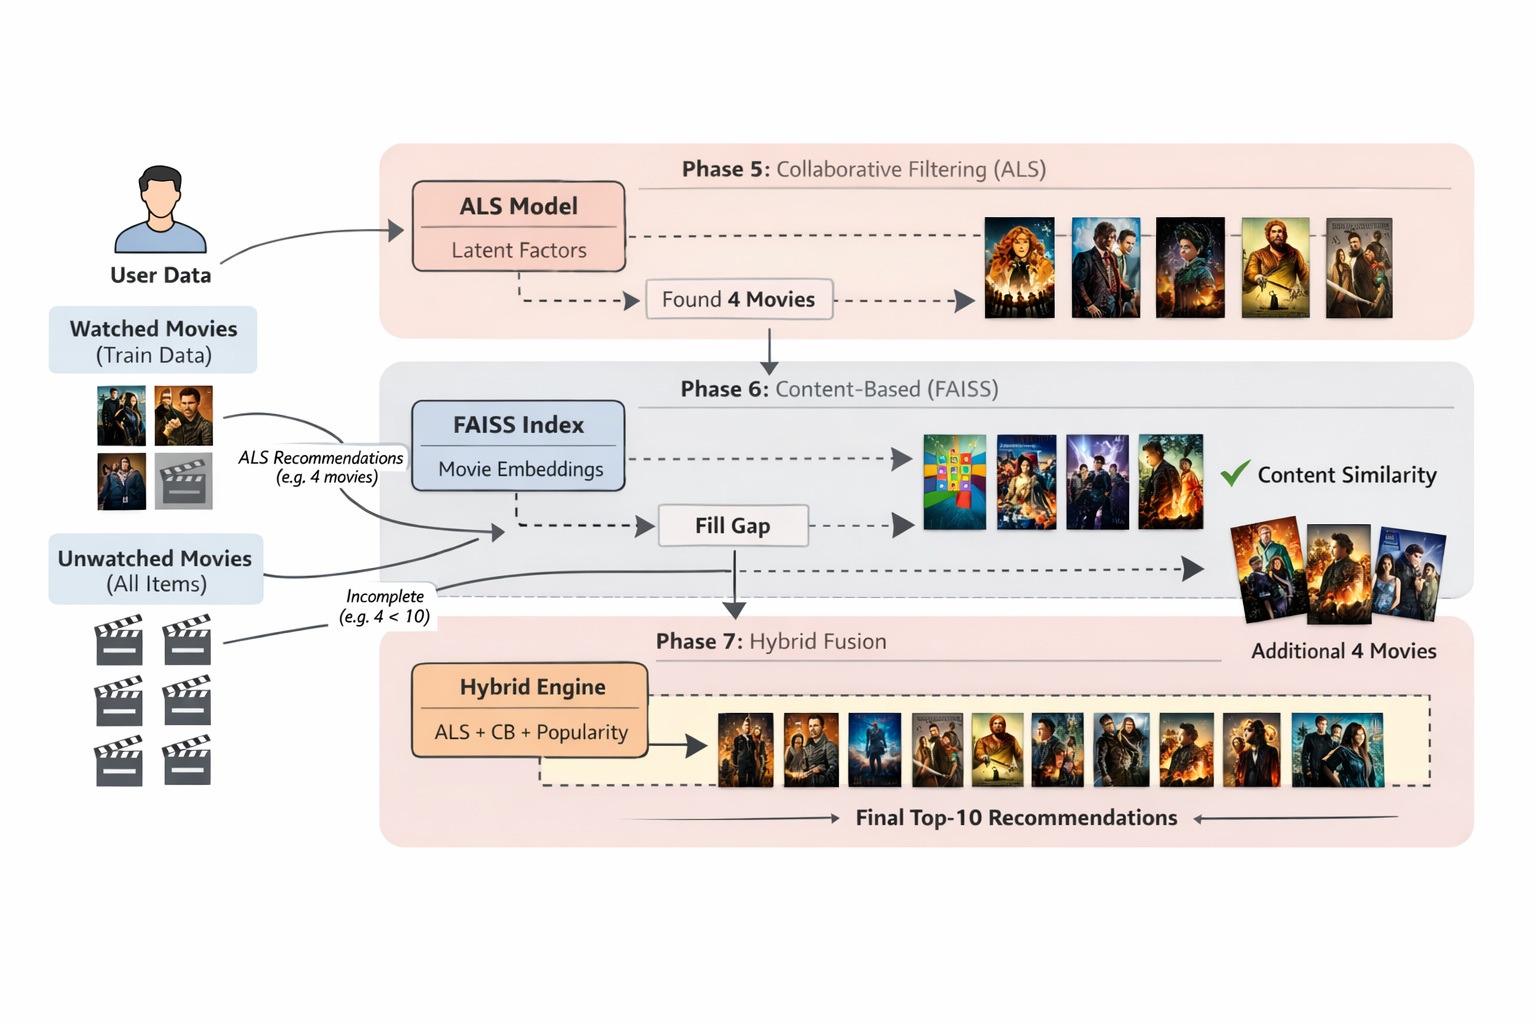

In [6]:

display(HTML(html_code))


## Alternative Hybrid Recommendation


In [ ]:
def hybrid_popularity(user_id, top_k=10):
    """
    Fallback for missing recommendations using globally popular movies.
    """
    # Movies already seen by user
    seen = train_df[train_df["userId"] == user_id]["movieId"].values

    # Rank movies by global popularity
    popular = train_df.groupby("movieId")["rating"].count().sort_values(ascending=False).index

    # Filter out already seen movies
    recs = [(m, 1.0) for m in popular if m not in seen]

    return recs[:top_k]


In [ ]:
def recommend_hybrid(user_id, top_k=10):
    """
    Hybrid recommendation combining:
    1. ALS Collaborative Filtering
    2. Content-Based (FAISS)
    3. Popularity fallback to guarantee top_k
    """
    # Step 1: ALS Recommendations
    recs_cf = recommend_als(user_id, top_k)

    # Step 2: Cold-start / empty ALS
    if recs_cf is None or len(recs_cf) == 0:
        recs_cf = content_based_recommendation(user_id, top_k)

    # Step 3: Fill remaining with Content-Based
    if len(recs_cf) < top_k:
        recs_cb = content_based_recommendation(user_id, top_k - len(recs_cf))
        recs_cf += recs_cb

    # Step 4: Fill remaining with Popularity fallback
    if len(recs_cf) < top_k:
        recs_pop = hybrid_popularity(user_id, top_k - len(recs_cf))
        recs_cf += recs_pop

    # Step 5: Ensure exactly top_k recommendations
    return recs_cf[:top_k]


In [ ]:
# Example for user_id = 10
user_id = 10
recs = recommend_hybrid(user_id, top_k=10)
print("Number of recommendations:", len(recs))
print("Sample recommendations:", recs[:5])

In [ ]:
from tqdm import tqdm
import numpy as np

K = 10

# Precompute Hybrid Recommendations for all test users
hybrid_test_predictions = {}

for user in tqdm(hybrid_test.index, desc="Evaluating Hybrid"):
    hybrid_test_predictions[user] = [movie for movie, _ in recommend_hybrid(user, K)]

# Helper functions (recall, precision, ndcg)
def recall_at_k(test_data, predictions, k=10):
    scores = []
    for user in test_data.index:
        true_items = test_data[user]
        pred_items = predictions[user]
        if len(true_items) == 0:
            continue
        hit = len(set(pred_items) & true_items)
        scores.append(hit / len(true_items))
    return np.mean(scores)

def precision_at_k(test_data, predictions, k=10):
    scores = []
    for user in test_data.index:
        true_items = test_data[user]
        pred_items = predictions[user]
        if len(pred_items) == 0:
            continue
        hit = len(set(pred_items) & true_items)
        scores.append(hit / k)
    return np.mean(scores)

def ndcg_at_k(test_data, predictions, k=10):
    scores = []
    for user in test_data.index:
        true_items = test_data[user]
        pred_items = predictions[user]
        dcg = 0
        idcg = 0
        for i, item in enumerate(pred_items):
            if item in true_items:
                dcg += 1 / np.log2(i + 2)
        for i in range(min(len(true_items), k)):
            idcg += 1 / np.log2(i + 2)
        if idcg > 0:
            scores.append(dcg / idcg)
    return np.mean(scores)

# Compute metrics
hybrid_recall = recall_at_k(hybrid_test, hybrid_test_predictions, K)
hybrid_precision = precision_at_k(hybrid_test, hybrid_test_predictions, K)
hybrid_ndcg = ndcg_at_k(hybrid_test, hybrid_test_predictions, K)

# Print results
print("=== Phase 7 Hybrid Evaluation ===")
print(f"Recall@{K}:    {hybrid_recall:.4f}")
print(f"Precision@{K}: {hybrid_precision:.4f}")
print(f"NDCG@{K}:      {hybrid_ndcg:.4f}")


In [ ]:
RECSYS_PROJECT/
│
├── app/
│   ├── __init__.py
│   └── streamlit_app.py
│
├── data/
│   │
│   ├── raw/
│   │   ├── movies.csv
│   │   ├── ratings.csv
│   │   ├── tags.csv
│   │   ├── links.csv
│   │   ├── checksums.txt
│   │   └── README.txt
│   │
│   ├── processed/
│   │   ├── als_results.csv
│   │   ├── hybrid_results.csv
│   │   ├── clean_interactions.csv
│   │   ├── clean_movies.csv
│   │   ├── clean_tags.csv
│   │   └── features.pkl
│   │
│   └── splits/
│       ├── train.csv
│       └── test.csv
│
├── models/
│   ├── als_model.pkl
│   ├── faiss.index
│   ├── item_features.npy
│   ├── item_map.pkl
│   ├── movieId_to_index.pkl
│   ├── user_map.pkl
│   ├── tfidf.pkl
│   ├── mlb.pkl
│   └── X_sparse.npz
│
├── notebooks/
│   └── experiments.ipynb
│
├── scripts/
│   ├── __pycache__/
│   └── run_pipeline.py
│
├── src/
│   │
│   ├── __init__.py
│   ├── config.py
│   ├── data_loader.py
│   ├── preprocessing.py
│   ├── features.py
│   ├── split.py
│   ├── inference.py
│   ├── evaluation.py
│   │
│   ├── als/
│   │   ├── __init__.py
│   │   ├── train.py
│   │   ├── recommend.py
│   │   └── evaluate.py
│   │
│   ├── content_based/
│   │   ├── __init__.py
│   │   ├── vectorize.py
│   │   └── search.py
│   │
│   ├── hybrid/
│   │   ├── __init__.py
│   │   └── hybrid.py
│   │
│   └── utils/
│       ├── __init__.py
│       └── metrics.py
│
├── requirements.txt
└── README.md


In [ ]:
# ==========================================
# Hybrid Recommender System (Silent by Default)
# ALS + Content-Based
# ==========================================

import numpy as np
import logging
from tqdm import tqdm

# ==========================================
# Silent Logger Configuration (THIS FILE ONLY)
# ==========================================
logger = logging.getLogger("HybridRecommender")
logger.propagate = False          # 🔕 do not propagate to root logger
logger.handlers.clear()           # 🔕 remove any existing handlers
logger.addHandler(logging.NullHandler())
logger.setLevel(logging.CRITICAL) # 🔕 silent by default

# ==========================================
# HybridRecommender Class
# ==========================================
class HybridRecommender:
    """
    Hybrid Recommender combining:
    - ALS Collaborative Filtering
    - Content-Based Similarity

    Design:
    - 🔕 Silent during large-scale evaluation
    - 📊 tqdm progress bar only
    - 🧪 Optional verbose logging for debugging
    """

    def __init__(self, als_recommender, content_searcher, train_df):
        self.als = als_recommender
        self.content = content_searcher
        self.train_df = train_df

    def recommend_weighted(
        self,
        user_id: int,
        top_k: int = 10,
        alpha: float = 0.7,
        verbose: bool = False,
        show_progress: bool = False,
    ):
        """
        Generate hybrid recommendations for a single user.

        Parameters
        ----------
        verbose : bool
            Enable detailed logging (ONLY for debugging / single user)
        show_progress : bool
            Enable tqdm (ONLY visual output during evaluation)
        """

        # Enable logging ONLY if verbose=True
        if verbose:
            logger.setLevel(logging.INFO)
            handler = logging.StreamHandler()
            handler.setFormatter(
                logging.Formatter("%(asctime)s | %(levelname)s | %(message)s")
            )
            logger.handlers = [handler]

            logger.info(f"🔍 Generating hybrid recommendations for user {user_id}")

        # ============================
        # ALS Recommendations
        # ============================
        recs_cf = self.als.recommend_als(user_id, top_k * 5)
        recs_cf_dict = dict(recs_cf) if recs_cf else {}

        # ============================
        # Content-Based Recommendations
        # ============================
        recs_cb = self.content.recommend(user_id, top_k * 5)
        recs_cb_dict = dict(recs_cb) if recs_cb else {}

        # ============================
        # Adaptive Alpha
        # ============================
        if not recs_cf_dict or np.mean(list(recs_cf_dict.values())) < 0.1:
            alpha = 0.3
            if verbose:
                logger.info("⚠️ Low ALS confidence → alpha adjusted to 0.3")

        # ============================
        # Merge Candidates
        # ============================
        all_items = set(recs_cf_dict) | set(recs_cb_dict)

        iterator = all_items
        if show_progress:
            iterator = tqdm(
                all_items,
                desc="🔄 Hybrid fusion",
                unit="item",
                leave=False,
            )

        # ============================
        # Score Fusion
        # ============================
        hybrid_scores = {}
        for item in iterator:
            hybrid_scores[item] = (
                alpha * recs_cf_dict.get(item, 0.0)
                + (1.0 - alpha) * recs_cb_dict.get(item, 0.0)
            )

        # ============================
        # Remove Seen Items
        # ============================
        seen_items = set(
            self.train_df.loc[
                self.train_df["userId"] == user_id, "movieId"
            ].values
        )

        for item in list(hybrid_scores.keys()):
            if item in seen_items:
                hybrid_scores.pop(item)

        # ============================
        # Rank Final Results
        # ============================
        top_items = sorted(
            hybrid_scores.items(),
            key=lambda x: x[1],
            reverse=True
        )[:top_k]

        if verbose:
            logger.info(
                f"🎯 Returned {len(top_items)} hybrid recommendations"
            )

        return top_items
